# Exploring Flow and Diffusion-based Generative Models with Scalable Interpolant Transformers (SiT)

Variant | Depth | Hidden Size | Patch Size | Heads
--- | --- | --- | --- | ---
SIT-XL | 28 | 1152 | 2/4/8 | 16
SIT-L | 24 | 1024 | 2/4/8 | 16
SIT-B | 12 | 768 | 2/4/8 | 12
SiT-S | 12 | 384 | 2/4/8 | 6

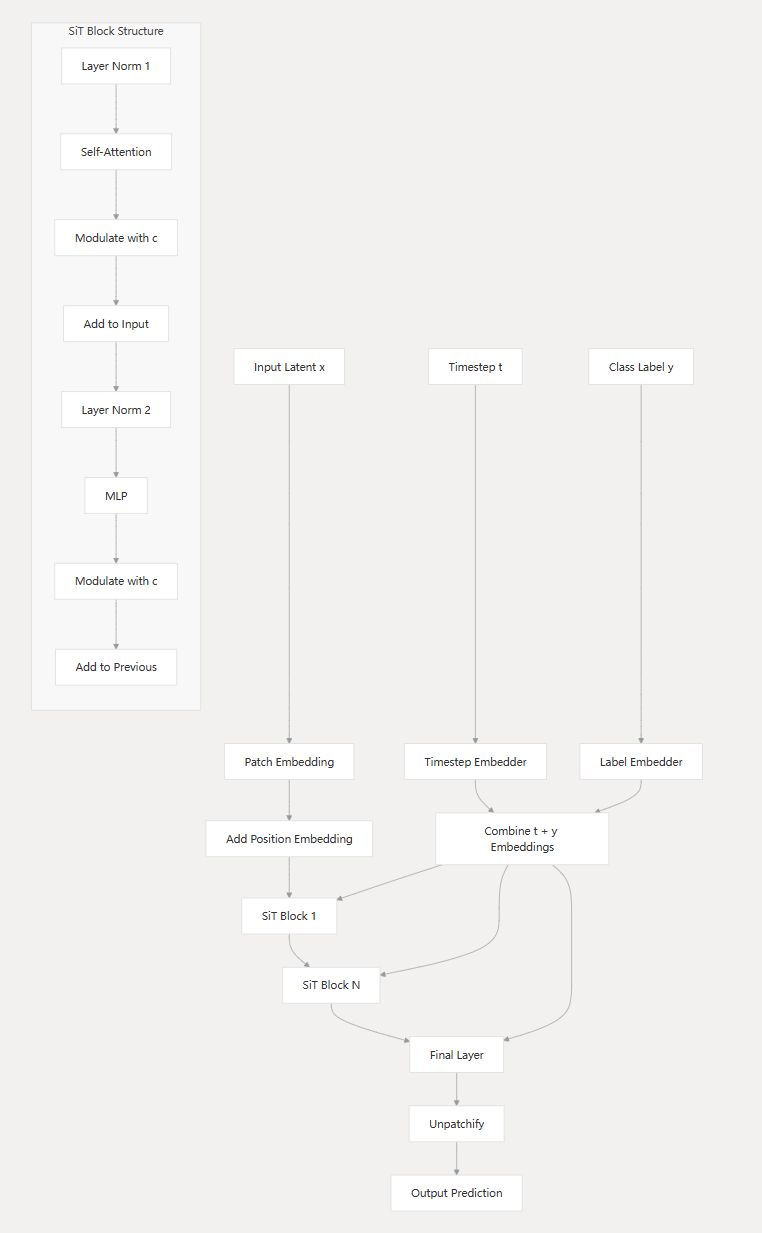

- 补丁嵌入：将输入图像或潜在表示转换为嵌入
- 位置嵌入：使用正弦嵌入添加位置信息
- 时间步长嵌入：将扩散时间步长嵌入到模型条件中
- 标签嵌入器：嵌入类别标签，支持无分类器指导
- SiT 块：带有自适应层归一化 (adaLN-Zero) 的 Transformer 块
- 最终层：将特征转换回所需的输出空间

SIT的核心创新是连接了flow-based model和diffusion-based model，在数据和噪声分布之间进行转换。

# Pipeline code

整个pipeline对应的代码

In [ ]:
import torch
def forward(self, x, t, y):
        """
        SiT 的前向传播。
        x: (N, C, H, W) 空间输入张量（图像或图像的潜在表示）
        t: (N,) 扩散时间步长张量
        y: (N,) 类别标签张量
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D)，其中 T = H * W / patch_size ** 2，代表token number
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D) 使用c进行modulate
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        if self.learn_sigma:
            x, _ = x.chunk(2, dim=1)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        SiT 的前向传播，同时也批量处理无条件前向传播以实现无分类器指导。
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # 为了精确重现默认情况下我们仅对三个通道应用无分类器指导。标准的 cfg 方法将其应用于所有通道。，
        # 可以通过取消注释下一行并注释掉再下一行来实现。
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

## Final layer

In [ ]:
class FinalLayer(nn.Module):
    """
    The final layer of SiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

## SiTBlock

In [ ]:
class SiTBlock(nn.Module):
    """
    A SiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x